In [1]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting

In [36]:
import warnings
warnings.filterwarnings('ignore')

import keras
import matplotlib.pyplot as plt # for plotting
import os # provides a way of using operating system dependent functionality
import cv2 #Image handling library
import numpy as np
import keras.backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.datasets import make_multilabel_classification
# Import of keras model and hidden layers for our convolutional network
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

# paths for dataset
data_path = "../input/dataset/leapGestRecog/leapGestRecog"

In [4]:
# Loading the images and their class(0 - 9)
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)    
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[5, 4, 4, ..., 3, 4, 2],
        [5, 4, 5, ..., 3, 3, 3],
        [4, 5, 4, ..., 4, 5, 3],
        ...,
        [4, 5, 5, ..., 5, 5, 5],
        [5, 5, 6, ..., 5, 7, 4],
        [4, 7, 5, ..., 5, 4, 4]], dtype=uint8),
 0]

In [5]:
# shuffle the input data
import random
random.shuffle(image_data)

In [6]:
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)
input_data[:5]

[array([[5, 4, 5, ..., 4, 4, 4],
        [4, 5, 6, ..., 3, 4, 3],
        [5, 5, 7, ..., 3, 4, 4],
        ...,
        [5, 5, 5, ..., 5, 4, 5],
        [5, 5, 5, ..., 3, 4, 5],
        [5, 4, 5, ..., 4, 4, 5]], dtype=uint8),
 array([[ 4,  5,  5, ...,  3,  4,  4],
        [ 5,  5,  5, ...,  4,  2,  5],
        [ 5,  5,  4, ...,  3,  3,  4],
        ...,
        [ 8,  8, 11, ...,  4,  4,  4],
        [ 8,  8, 10, ...,  4,  5,  3],
        [ 7,  8, 11, ...,  3,  5,  4]], dtype=uint8),
 array([[5, 6, 5, ..., 5, 5, 4],
        [5, 6, 5, ..., 5, 5, 4],
        [5, 5, 6, ..., 5, 4, 4],
        ...,
        [4, 5, 5, ..., 5, 5, 5],
        [3, 4, 5, ..., 5, 6, 5],
        [5, 7, 5, ..., 6, 6, 6]], dtype=uint8),
 array([[4, 5, 3, ..., 3, 4, 4],
        [5, 5, 5, ..., 4, 5, 4],
        [4, 5, 4, ..., 4, 4, 4],
        ...,
        [5, 5, 5, ..., 4, 4, 4],
        [4, 5, 5, ..., 4, 4, 5],
        [5, 4, 4, ..., 4, 4, 3]], dtype=uint8),
 array([[5, 5, 5, ..., 5, 4, 5],
        [4, 5, 6, ..., 5, 4

In [7]:
label[:10]

[6, 8, 2, 2, 6, 7, 1, 3, 3, 7]

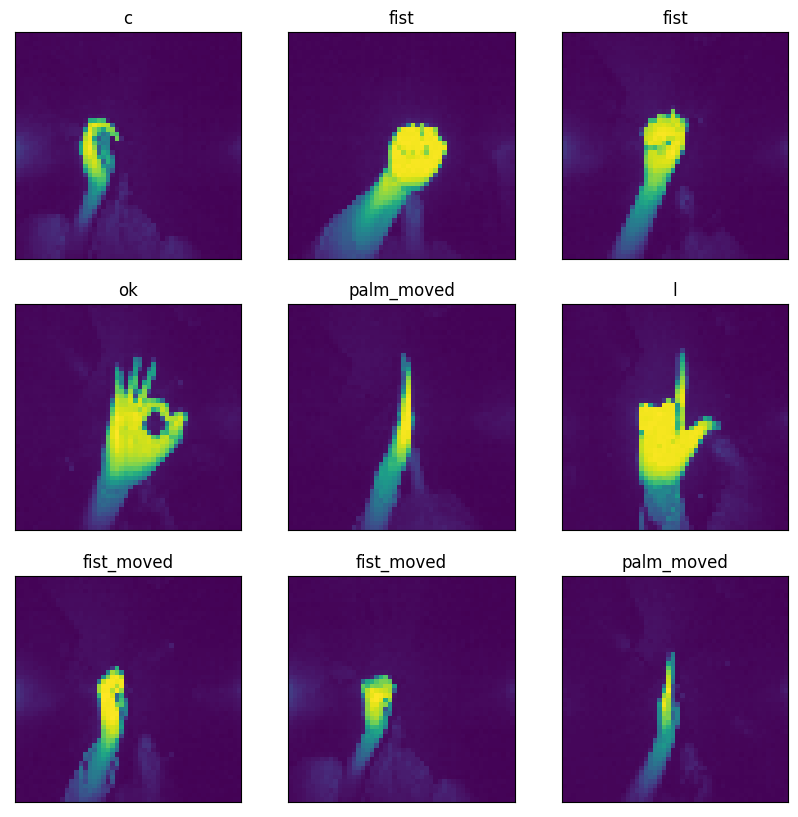

In [8]:
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0])
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
#plt.show()

In [9]:
# Normalizing the data
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [10]:
from sklearn.datasets import make_multilabel_classification
X,y=make_multilabel_classification(n_samples=500,n_features=4,n_classes=2,n_labels=3,random_state=1)
X

array([[ 9., 12.,  6., 12.],
       [ 5.,  2., 12., 22.],
       [15.,  5., 12., 11.],
       ...,
       [ 5., 10., 15., 28.],
       [ 0.,  8., 16., 27.],
       [ 6.,  9., 13., 22.]])

In [11]:
X=(X-X.min())/(X.max()-X.min())
X

array([[0.20454545, 0.27272727, 0.13636364, 0.27272727],
       [0.11363636, 0.04545455, 0.27272727, 0.5       ],
       [0.34090909, 0.11363636, 0.27272727, 0.25      ],
       ...,
       [0.11363636, 0.22727273, 0.34090909, 0.63636364],
       [0.        , 0.18181818, 0.36363636, 0.61363636],
       [0.13636364, 0.20454545, 0.29545455, 0.5       ]])

In [12]:
# one hot encoding
label = keras.utils.to_categorical(label, num_classes=10,dtype='i1')
label[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int8)

In [13]:
# reshaping the data
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.10, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.10)
# X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

In [15]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int8)

In [16]:

classes, counts = np.unique(y_train, return_counts=True)

classes

array([0, 1], dtype=int8)

In [17]:
# # Plotting class distribution
# plt.barh(CATEGORIES, counts)
# plt.title('Class distribution in training set')
# plt.xlabel('Count')
# plt.ylabel('Classes')
# plt.show()

In [24]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Add, BatchNormalization, Activation

def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut connection
    shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size=(kernel_size, kernel_size), strides=(stride, stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size=(kernel_size, kernel_size), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Shortcut connection to adjust size if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Add the shortcut value to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

def ResNet50():
    input_tensor = Input(shape=(50, 50, 1))
    
    # Initial convolutional layer
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, filters=64, kernel_size=3, stride=1)
    x = residual_block(x, filters=64, kernel_size=3, stride=1)
    x = residual_block(x, filters=64, kernel_size=3, stride=1)
    
    x = residual_block(x, filters=128, kernel_size=3, stride=2)  # Down-sampling
    x = residual_block(x, filters=128, kernel_size=3, stride=1)
    x = residual_block(x, filters=128, kernel_size=3, stride=1)
    
    x = residual_block(x, filters=256, kernel_size=3, stride=2)  # Down-sampling
    x = residual_block(x, filters=256, kernel_size=3, stride=1)
    x = residual_block(x, filters=256, kernel_size=3, stride=1)
    
    x = residual_block(x, filters=512, kernel_size=3, stride=2)  # Down-sampling
    x = residual_block(x, filters=512, kernel_size=3, stride=1)
    x = residual_block(x, filters=512, kernel_size=3, stride=1)
    
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(10, activation='softmax')(x)  # Misalnya, 1000 kelas dalam arsitektur ResNet
    
    model = Model(inputs=input_tensor, outputs=x)
    return model

# Membuat model ResNet50
model = ResNet50()
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d_140 (Conv2D)            (None, 25, 25, 64)   3200        ['input_6[0][0]']                
                                                                                                  
 batch_normalization_140 (Batch  (None, 25, 25, 64)  256         ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_125 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_140[0

In [25]:
r =model.fit(X_train, y_train, epochs = 7, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/7
563/563 [==============================] - 371s 645ms/step - loss: 0.3700 - accuracy: 0.9111 - val_loss: 11.4108 - val_accuracy: 0.3390
Epoch 2/7
563/563 [==============================] - 368s 653ms/step - loss: 0.0570 - accuracy: 0.9853 - val_loss: 0.6624 - val_accuracy: 0.8435
Epoch 3/7
563/563 [==============================] - 384s 682ms/step - loss: 0.0440 - accuracy: 0.9891 - val_loss: 0.0123 - val_accuracy: 0.9950
Epoch 4/7
563/563 [==============================] - 419s 744ms/step - loss: 0.0555 - accuracy: 0.9879 - val_loss: 8.4678 - val_accuracy: 0.5615
Epoch 5/7
563/563 [==============================] - 415s 737ms/step - loss: 0.0379 - accuracy: 0.9931 - val_loss: 2.7589e-04 - val_accuracy: 1.0000
Epoch 6/7
563/563 [==============================] - 449s 797ms/step - loss: 0.0115 - accuracy: 0.9977 - val_loss: 0.0110 - val_accuracy: 0.9960
Epoch 7/7
563/563 [==============================] - 453s 805ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 1.0465e-04

In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d_140 (Conv2D)            (None, 25, 25, 64)   3200        ['input_6[0][0]']                
                                                                                                  
 batch_normalization_140 (Batch  (None, 25, 25, 64)  256         ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_125 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_140[0

                                                                                                  
 activation_133 (Activation)    (None, 7, 7, 128)    0           ['add_63[0][0]']                 
                                                                                                  
 conv2d_150 (Conv2D)            (None, 7, 7, 128)    147584      ['activation_133[0][0]']         
                                                                                                  
 batch_normalization_150 (Batch  (None, 7, 7, 128)   512         ['conv2d_150[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_134 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_150[0][0]']
                                                                                                  
 conv2d_15

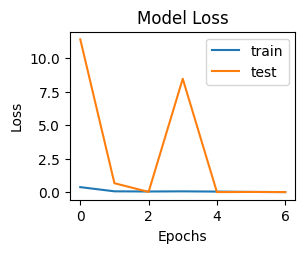

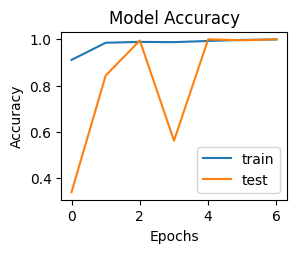

In [27]:
plt.subplot(2, 2, 1)
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [37]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

63/63 [==============================] - 4s 66ms/step


In [38]:



print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1)))

Test accuracy: 100.00%
63/63 [==============================] - 4s 64ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       198
           2       1.00      1.00      1.00       215
           3       1.00      1.00      1.00       218
           4       1.00      1.00      1.00       194
           5       1.00      1.00      1.00       203
           6       1.00      1.00      1.00       199
           7       1.00      1.00      1.00       207
           8       1.00      1.00      1.00       188
           9       1.00      1.00      1.00       187

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [29]:
# val_loss, val_accuracy = model.evaluate(X_val, y_val)

# print('Val accuracy: {:2.2f}%'.format(val_accuracy*100))

63/63 [==============================] - 5s 67ms/step


[]

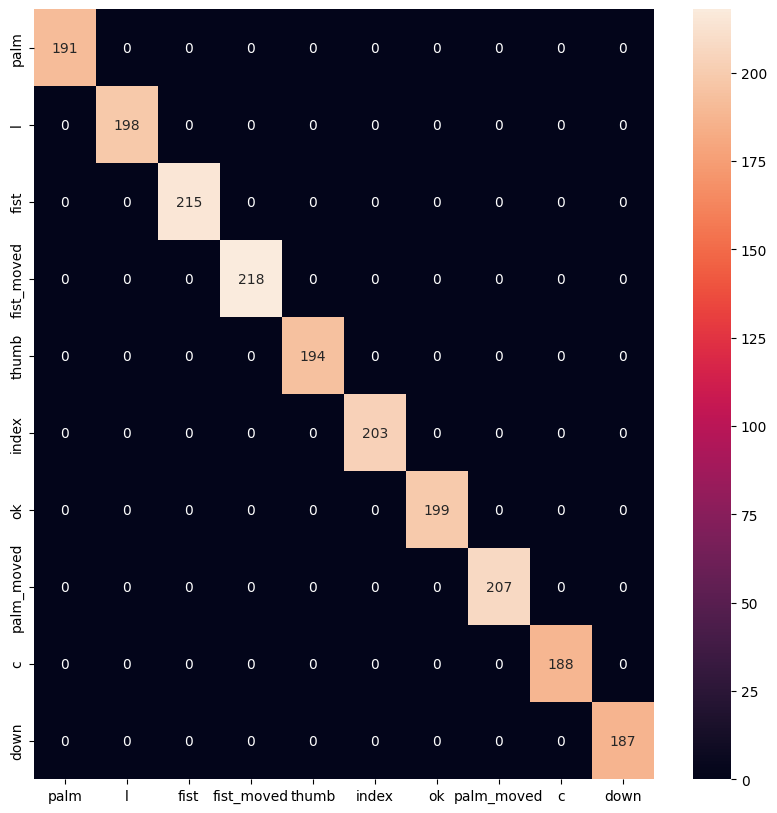

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cat = [c[3:] for c in CATEGORIES]
plt.figure(figsize=(10,10))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
sn.heatmap(cm, annot=True,fmt='d',xticklabels=cat, yticklabels=cat)
plt.plot()

In [35]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
# Menghitung F1 score
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)


63/63 [==============================] - 4s 65ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

1/1 [==============================] - 0s 41ms/step


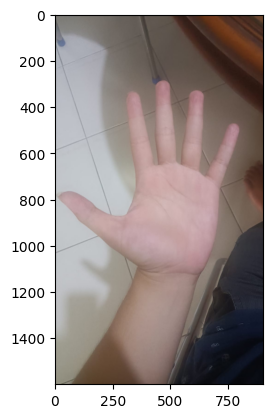

Label : palm


In [39]:
# Load the image and resize it to 32x32 pixels
image1 = Image.open('image/ket.jpg')
#image = Image.open('/content/asd.jpg')
image = image1.convert('L')
image = image.resize((50, 50))

# Convert the image to a numpy array and normalize its values
image_array = np.array(image) / 255.0


image_array = image_array.reshape((1, 50, 50, 1))  


# Pass the image through the model to get the predicted class probabilities
predictions = model.predict(image_array)

# Get the index of the predicted class with the highest probability
predicted_class = np.argmax(predictions[0])

if predicted_class == 0 :
    label = "palm"
else :
    label = "No Palm"
    
# Get the corresponding label from the class_names list
# label = CATEGORIES[predicted_class]



plt.imshow(image1)
plt.show()

print("Label :", label)



